In [1]:
import psycopg2 as ps
import pandas as pd
import numpy as np

import requests
import json
import io

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from sklearn.metrics import ndcg_score, accuracy_score
import random

import chgk_api as cha

# настройки pandas, с которыми лучше почти всегда
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)

In [2]:
# настройки

# количество вопросов "виртуальной перестрелки", кототорое планируем моделировать
test_distnce = 8

# процентили, на которые мы разделили выборрку турнира по стартовому рейтингу
first_percentile = 0.1
second_percentile = 0.5

# количество команд, которые участвуют в построении метрики
k_opt = 200

# тестовый турнир для проверки работы функций
# гостинный двор-2024, калуга
tourn_id = 10707
# Островок Бесконечности: октябрь
# tourn_id = 10396

In [3]:
def make_metrics(df, segment_col, target_col, pred_col, k=5, is_size=True, suffix='', param_value='', param_col='', tourn_id=0):
    """
    Функция для точности прогноза. 
    Сейчас это ndcg_score https://scikit-learn.org/dev/modules/generated/sklearn.metrics.ndcg_score.html
    """
    work_df = df.copy()
    work_df.sort_values(by=[target_col, segment_col], ascending=[True, True])
    grouped = work_df.groupby(segment_col)
    ndcg_lst = []
    acc_lst = []

    for name, group in grouped:
        group = group.sort_values(by=target_col)
        y_true = np.array([group[target_col]])
        y_pred = np.array([group[pred_col]])
        
        ndcg = ndcg_score(y_true, y_pred, k=k)
        ndcg_lst.append({segment_col: name, 'ndcg': ndcg})

        # accuracy_score не работает с float, 
        # поэтому выводим дробную часть в виде числа
        # y_true = (y_true * 10).astype('int')
        # y_pred = (y_pred * 10).astype('int')
        # поэтому округляем вниз, делённое место считаем целевым
        y_true = np.floor(y_true).astype('int')
        y_pred = np.floor(y_pred).astype('int')

        acc = accuracy_score(y_true[0], y_pred[0])
        acc_lst.append({segment_col: name, 'accuracy': acc})

    metrics_df = work_df.groupby(segment_col).agg(
                                                    size = ('team_id', 'nunique'),
                                                    ).reset_index()
    ndcg_df = pd.DataFrame(ndcg_lst)
    acc_df = pd.DataFrame(acc_lst)

    metrics_df = metrics_df.merge(ndcg_df, 'left', on=segment_col)
    metrics_df = metrics_df.merge(acc_df, 'left', on=segment_col)

    if is_size == False:
        del metrics_df['size']
        metrics_df.columns = ['segment', 'ndcg'+suffix, 'accuracy'+suffix]
    else:
        metrics_df.columns = ['segment', 'size', 'ndcg'+suffix, 'accuracy'+suffix]
    
    metrics_df['tourn_id'] = tourn_id
    metrics_df[param_col] = param_value

    return metrics_df

def get_target(df):
    """
    Функция для расчёта целевой метрики
    Сейчас - это ранг суммы взятых с усреднением
    """
    totals_df = df.groupby(['tourn_id', 'team_id']).agg(
        target_question = ('qv_result', 'sum'),
    ).reset_index()
    totals_df['target'] = totals_df.groupby(['tourn_id'])['target_question'].rank(method='average', ascending=False)

    return totals_df

def get_current_taken_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза "по взятым".
    В конце турнира команда займёт такое место, какое занимает на этап после qv_num вопроса
    """
    gr_df = df[df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', segment_col]).agg(
        current_res = ('qv_result', 'sum'),
    ).reset_index()

    totals_df = get_target(df)
    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])
    gr_df['current_place'] = gr_df.groupby(['tourn_id'])['current_res'].rank(method='average', ascending=False)
    gr_df = gr_df.sort_values(by='target_question', ascending=False)

    return gr_df

def get_current_qv_rating_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза "по рейтингу взятых вопросов".
    В конце турнира команда займёт такое место, какое занимает на этап после qv_num по рейтингу взятых
    """
    # статистика по вопросам
    qv_stat_df = df.groupby(['tourn_id', 'question_num']).agg(
        taked = ('qv_result', 'sum'),
        total = ('qv_result', 'count'),
    ).reset_index()
    # рейтинг вопроса - количество команд, которые его не взяли
    qv_stat_df['qv_rating'] = qv_stat_df['total'] - qv_stat_df['taked']

    qv_df = df.merge(qv_stat_df, 'left', on=['tourn_id', 'question_num'])
    # вопросный рейтинг команды - суммарный рейтинг вопросов, которые она взяла  
    qv_df['rating'] = qv_df['qv_rating'] * qv_df['qv_result'] 

    gr_df = qv_df[qv_df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', segment_col]).agg(
        current_rating = ('rating', 'sum'),
    ).reset_index()
    gr_df['rating_place'] = gr_df.groupby(['tourn_id'])['current_rating'].rank(method='average', ascending=False)

    totals_df = get_target(df)

    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])

    return gr_df

def get_data(tourn_id):
    """
    Функция для сборки датасета и проставлении необхоимых полей
    """
    # получаем данные по API
    tourn_df, question_df, players_df = cha.get_tourn_result(tourn_id)
    qv_stat = cha.tourn_stat(question_df)

    # назначаем командам сегмент по стартовой крутости
    tourn_df['segment'] =np.where(
        (tourn_df['predictedPosition'] <= tourn_df['predictedPosition'].quantile(.1)), '1.top_10%',
        np.where(
                    (tourn_df['predictedPosition'] <= tourn_df['predictedPosition'].quantile(.5)) &
                    (tourn_df['predictedPosition'] > tourn_df['predictedPosition'].quantile(.1)), '2.top_50%', '3.bottom_50%'
                )
                                )
    

    # собираем нужный датасет
    work_df = qv_stat.merge(tourn_df[['tourn_id', 'team_id', 'predictedPosition', 'position', 'segment']], 'left', on=['tourn_id', 'team_id'])
    work_df['qv_result'] = work_df['qv_result'].astype('int')

    work_df = work_df.sort_values(by=['tourn_id', 'predictedPosition', 'segment', 'team_id', 'question_num'])

    return tourn_df, question_df, players_df, work_df

In [4]:
# проверяем работу функций
# собранный датассет по одному турниру
tourn_df, question_df, players_df, work_df = get_data(tourn_id)
work_df.sample(3)

200


,tourn_id,team_id,numqv,question_num,qv_result,predictedPosition,position,segment
2876,10707,87772,90,41,1,28,35.5,2.top_50%
4471,10707,87812,90,63,1,55,69.5,3.bottom_50%
5288,10707,46022,90,75,0,36,35.5,2.top_50%


In [5]:
# прогноз по занятому месту к 12 вопросу по сегменту стартовой крутости
grtf = get_current_taken_forecast(work_df, 12, 'segment')
grtf.sample(3)

,tourn_id,team_id,segment,current_res,target_question,target,current_place
50,10707,62806,3.bottom_50%,7,36,50.5,14.0
41,10707,50319,2.top_50%,6,56,9.0,26.5
64,10707,87812,3.bottom_50%,3,23,69.5,67.0


In [7]:
# метрики точности прогноза по сегментам
make_metrics(
                grtf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='current_place', 
                is_size=True, 
                k=k_opt,
                suffix='_current_taken', 
                tourn_id=tourn_id)

,segment,size,ndcg_current_taken,accuracy_current_taken,tourn_id,
0,1.top_10%,8,0.907209,0.125000,10707,
1,2.top_50%,28,0.957981,0.035714,10707,
2,3.bottom_50%,35,0.964864,0.028571,10707,


In [8]:
# по всей выборке тоже можно сделать
make_metrics(
                grtf, 
                segment_col='tourn_id', 
                target_col='target', 
                pred_col='current_place', 
                is_size=True, 
                suffix='_current_taken', 
                tourn_id=tourn_id)

,segment,size,ndcg_current_taken,accuracy_current_taken,tourn_id,
0,10707,71,0.87328,0.042254,10707,


In [9]:
# прогноз по рейтингу взятых вопросов к 12 вопросу по сегменту стартовой крутости
gcqrf = get_current_qv_rating_forecast(work_df, 12, 'segment')
gcqrf.sample(3)

,tourn_id,team_id,segment,current_rating,rating_place,target_question,target
21,10707,38164,3.bottom_50%,120,46.0,40,40.0
8,10707,2065,3.bottom_50%,93,57.0,38,46.5
3,10707,336,3.bottom_50%,111,48.0,45,25.5


In [10]:
# метрики точности прогноза по сегментам
make_metrics(
                gcqrf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='rating_place', 
                is_size=True, 
                suffix='_qv_rating_forecast', 
                tourn_id=tourn_id)

,segment,size,ndcg_qv_rating_forecast,accuracy_qv_rating_forecast,tourn_id,
0,1.top_10%,8,0.868627,0.125000,10707,
1,2.top_50%,28,0.873273,0.000000,10707,
2,3.bottom_50%,35,0.934270,0.028571,10707,


In [11]:
# прогноз по стартовому рейтингу
trdf = work_df[['tourn_id', 'team_id', 'position', 'predictedPosition', 'segment']].drop_duplicates()
make_metrics(
                trdf, 
                segment_col='segment', 
                target_col='position', 
                pred_col='predictedPosition', 
                is_size=True, 
                suffix='_start_rating', 
                tourn_id=tourn_id)

,segment,size,ndcg_start_rating,accuracy_start_rating,tourn_id,
0,1.top_10%,8,0.834681,0.375000,10707,
1,2.top_50%,28,0.858742,0.035714,10707,
2,3.bottom_50%,35,0.983832,0.057143,10707,


In [12]:
# прогноз по случайной тасовке команд
places = list(range(1, len(trdf)+1))
random.shuffle(places)
trdf['random'] = places
make_metrics(
                trdf, 
                segment_col='segment', 
                target_col='position', 
                pred_col='random', 
                is_size=True, 
                suffix='_start_rating', 
                tourn_id=tourn_id)

,segment,size,ndcg_start_rating,accuracy_start_rating,tourn_id,
0,1.top_10%,8,0.770722,0.000000,10707,
1,2.top_50%,28,0.348006,0.035714,10707,
2,3.bottom_50%,35,0.760881,0.028571,10707,


In [13]:
# а теперь проход по всем вопроса турнира
num_of_questions = work_df['numqv'].values[0]
num_of_teams = work_df['team_id'].nunique()

questions = pd.DataFrame(range(1, num_of_questions+1), columns=['question_num'])
questions['tourn_id'] = tourn_id

# прогноз по стартовому рейтингу
teams_smpl = work_df[['tourn_id', 'team_id', 'position', 'predictedPosition', 'segment']].drop_duplicates()
start_df_forec = make_metrics(
                teams_smpl, 
                segment_col='segment', 
                target_col='position', 
                pred_col='predictedPosition', 
                is_size=True, 
                k=k_opt,
                suffix='_start_rating_forecast', 
                tourn_id=tourn_id)

res_df = questions.merge(start_df_forec, 'left', on='tourn_id')

# прогноз по случайной тасовке команд
places= list(range(1, len(teams_smpl)+1))
random.shuffle(places)
teams_smpl['random'] = places
# shuffle_forecast = make_metrics(teams_smpl, 'segment', 'position', 'random')
shuffle_forecast = make_metrics(
                teams_smpl, 
                segment_col='segment', 
                target_col='position', 
                pred_col='random', 
                is_size=False, 
                k=k_opt,
                suffix='_shuffle_forecast', 
                tourn_id=tourn_id)


res_df = res_df.merge(shuffle_forecast, 'left', on=['segment'], suffixes=('', '_random'))

qv_forecast_metric_df = pd.DataFrame()
rating_forecast_metric_df = pd.DataFrame()
for i in range(1, num_of_questions+1):
    qv_forecast_df = get_current_taken_forecast(work_df, i, 'segment')
    rating_forecast_df = get_current_qv_rating_forecast(work_df, i, 'segment')

    qv_forecast_metric_df_b = make_metrics(
                    qv_forecast_df, 
                    segment_col='segment', 
                    target_col='target', 
                    pred_col='current_place', 
                    is_size=False, 
                    k=k_opt,
                    suffix='_current_place_forecast', 
                    param_value=i,
                    param_col='question_num', 
                    tourn_id=tourn_id)
#     rating_forecast_metric_df_b = make_metrics(rating_forecast_df, 'segment', 'target', 'rating_place')
    rating_forecast_metric_df_b = make_metrics(
                    rating_forecast_df, 
                    segment_col='segment', 
                    target_col='target', 
                    pred_col='rating_place', 
                    is_size=False, 
                    k=k_opt,
                    suffix='_qv_rating_place_forecast', 
                    param_value=i,
                    param_col='question_num', 
                    tourn_id=tourn_id)

    qv_forecast_metric_df = pd.concat([qv_forecast_metric_df, qv_forecast_metric_df_b])
    rating_forecast_metric_df = pd.concat([rating_forecast_metric_df, rating_forecast_metric_df_b])

res_df = res_df.merge(qv_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])
res_df = res_df.merge(rating_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])

In [14]:
len(res_df)

270

In [15]:
res_df.sample(3)

,question_num,tourn_id,segment,size,ndcg_start_rating_forecast,accuracy_start_rating_forecast,,ndcg_shuffle_forecast,accuracy_shuffle_forecast,tourn_id_random,_random,ndcg_current_place_forecast,accuracy_current_place_forecast,ndcg_qv_rating_place_forecast,accuracy_qv_rating_place_forecast
97,33,10707,2.top_50%,28,0.931108,0.035714,,0.836067,0.0,10707,,0.967109,0.00,0.961045,0.035714
204,69,10707,1.top_10%,8,0.935250,0.375000,,0.992575,0.0,10707,,0.875072,0.25,0.877030,0.125000
3,2,10707,1.top_10%,8,0.935250,0.375000,,0.992575,0.0,10707,,0.940416,0.00,0.940416,0.000000


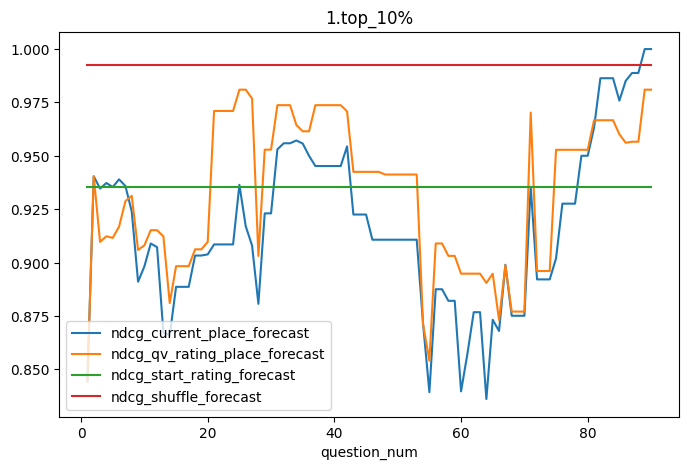

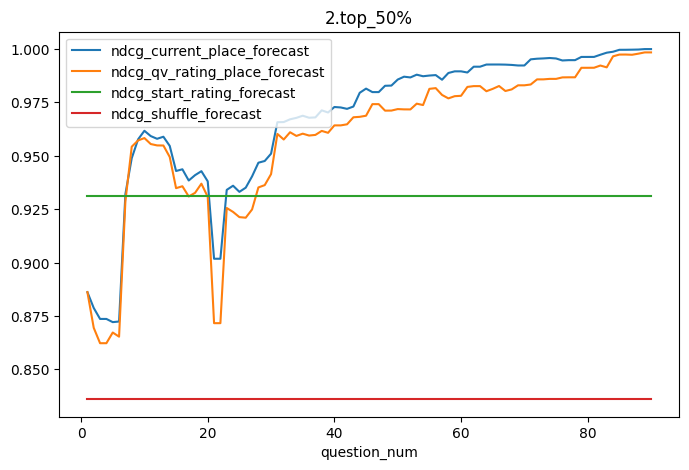

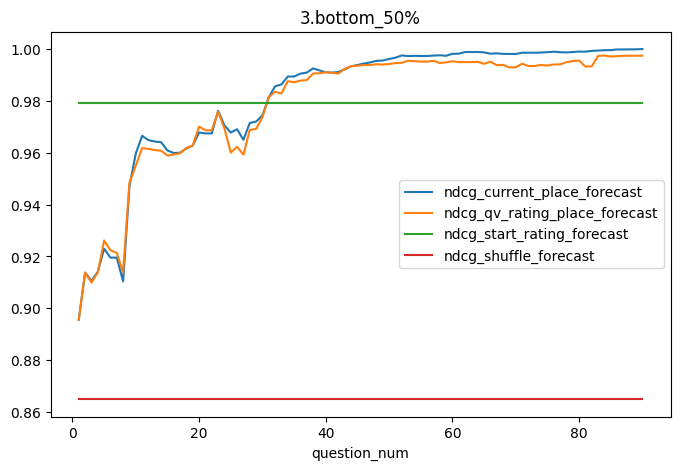

In [16]:
for segment in res_df['segment'].unique():
    res_df[res_df['segment'] == segment].set_index('question_num')[[
                                                                    'ndcg_current_place_forecast', 
                                                                    'ndcg_qv_rating_place_forecast',
                                                                    'ndcg_start_rating_forecast', 
                                                                    'ndcg_shuffle_forecast', 
                                                                    ]].plot(title=segment)

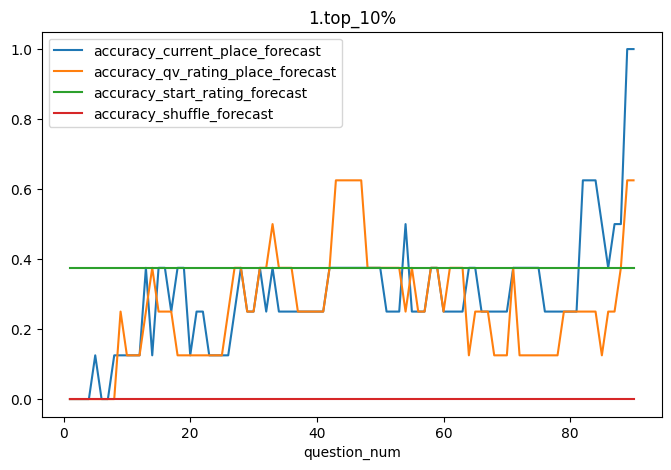

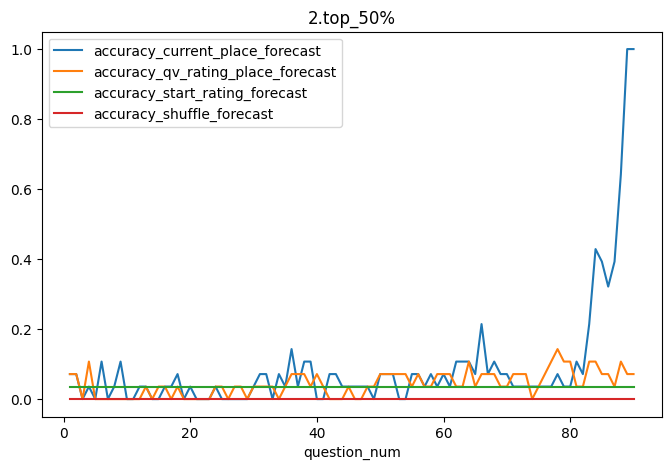

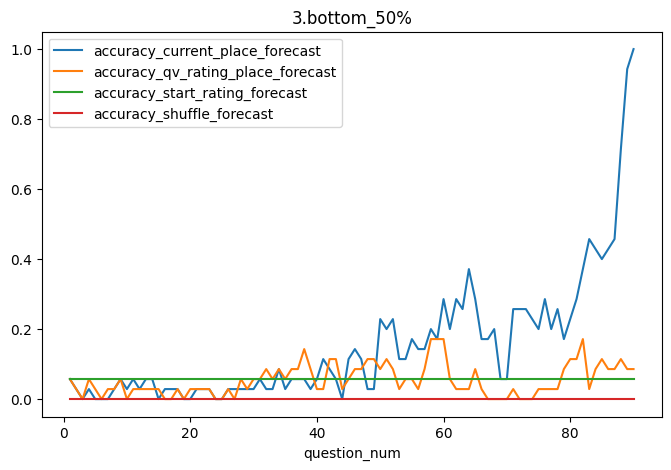

In [17]:
for segment in res_df['segment'].unique():
    res_df[res_df['segment'] == segment].set_index('question_num')[[
                                                                    'accuracy_current_place_forecast', 
                                                                    'accuracy_qv_rating_place_forecast',
                                                                    'accuracy_start_rating_forecast', 
                                                                    'accuracy_shuffle_forecast', 
                                                                    ]].plot(title=segment)

In [18]:
# в качестве прогноза берём ситуацию перед начало "виртуальной перестрелки"
res_df[res_df['question_num'] == num_of_questions - test_distnce].set_index('segment').T

segment,1.top_10%,2.top_50%,3.bottom_50%
question_num,82,82,82
tourn_id,10707,10707,10707
size,8,28,35
ndcg_start_rating_forecast,0.93525,0.931108,0.97926
accuracy_start_rating_forecast,0.375,0.035714,0.057143
,,,
ndcg_shuffle_forecast,0.992575,0.836067,0.864934
accuracy_shuffle_forecast,0.0,0.0,0.0
tourn_id_random,10707,10707,10707
_random,,,
